In [ ]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt


## Load data 

In [ ]:
def load_data(data_fname,benchmark_fname):
  data = pd.read_csv(data_fname, index_col=0) 
  X = data.values[:, 2:].astype('float64') 
  years = data['year'] 
  X_train = X[years < 2020.] 
  X_valid = X[years == 2020.] 
  tmp = data.index[data['year'] == 2020.] 
  tickers = np.array([ticker.rstrip('_2020') for ticker in tmp]) 
  benchmark = pd.read_csv(benchmark_fname, index_col=0) 
  return data, X_train, X_valid, tickers, benchmark

In [ ]:
data, X_train, X_valid, tickers, benchmark= load_data('assign3_data.csv','assign3_benchmark.csv')

#0. plot a comparision of the stock from portfolio (from assignment 2 and the IBB on the validation data.

Assignment 2 portfolio:
Most communal
-------------
['CARA', 'AXON', 'ITCI', 'VCYT', 'CHRS']


Least communal
-------------
['PTCT', 'ASND', 'ACAD', 'PBYI', 'CLDX', 'BLCM', 'TLGT', 'ACOR', 'CMRX', 'AUPH', 'CLVS', 'ENDP', 'BMRN', 'MNKD', 'AKBA', 'AMGN', 'BPMC', 'OPK', 'TXMD', 'LGND']


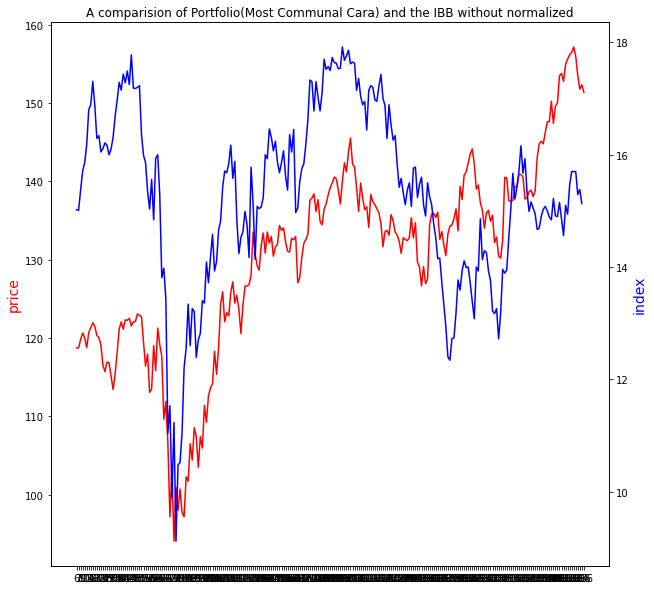

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(benchmark.loc["IBB_2020"][1:], label="IBB Index", color="red")
ax.set_ylabel("price",color="red",fontsize=14)
ax1 = ax.twinx()
ax1.plot(X_valid[np.where(tickers == "CARA")[0][0]],label="Most Communal Stock with IBB ", color="blue")
ax1.set_ylabel("index",color="blue",fontsize=14)
plt.title("A comparision of Portfolio(Most Communal Cara) and the IBB without normalized")
plt.show()



#Modify the benchmark

In [ ]:
def modify_target(target, threshold=-0.05):
    """
    threshold has to be negative
    """
    cols = target.columns[1:]
    # Get the returns
    returns = target[cols].pct_change(axis=1)
    # Remove drawdowns less than threshold
    returns[returns < threshold] = np.abs(threshold)
    # Reconstruct
    target_mod = target.copy()
    target_mod[cols] = returns
    target_mod[cols[0]] = target[cols[0]]

    for i, col in enumerate(cols[1:]):
        target_mod[col] = target_mod[cols[i]] * (target_mod[col] + 1)

    return target_mod

In [ ]:
#check modify benchmark
modify_benchmark = modify_target(benchmark)
modify_benchmark

,year,6,7,8,9,10,13,14,15,16,17,21,22,23,24,27,28,29,30,31,34,35,36,37,38,41,42,43,44,45,49,50,51,52,55,56,57,58,59,62,...,309,310,311,314,315,316,317,318,321,322,323,324,325,328,329,330,332,335,336,337,338,339,342,343,344,345,346,349,350,351,352,353,356,357,358,359,363,364,365,366
IBB_2016,2016.0,107.681877,105.758530,101.365074,99.527344,96.065979,97.551285,102.428849,106.560528,103.906037,101.587885,104.384988,101.920600,105.310060,103.547692,103.138196,99.964452,96.333738,97.642701,98.183857,95.434263,96.527509,96.779808,93.690182,90.721238,90.823616,91.383033,89.229439,91.843739,94.596941,97.375799,94.852900,95.734105,96.388565,94.121632,94.618904,94.816343,95.609764,92.904087,96.991883,...,90.399373,92.168052,95.635767,95.800561,104.358239,106.112239,105.460455,107.324321,106.679847,104.914836,105.650880,104.259359,104.988060,103.028999,103.900523,104.164155,102.527340,102.644515,100.359532,98.682408,99.037627,99.575894,100.458413,97.506984,98.327213,98.748347,97.964701,98.521281,98.656777,99.579579,99.755300,98.426085,99.206064,98.081877,97.694318,99.752979,99.364692,98.199831,97.844519,97.210793
IBB_2017,2017.0,89.165504,91.471832,91.758888,92.471581,93.797989,94.530449,91.706108,92.032745,92.389099,90.577675,91.333252,90.564491,90.214722,89.366753,89.089592,89.970566,89.647217,90.432487,89.214973,91.749001,92.524384,92.346191,93.392128,93.553825,93.180962,92.953300,93.890366,93.827675,94.464485,95.619301,97.318535,96.668533,97.120583,96.609146,95.787567,95.460937,95.652283,98.413979,98.070808,...,103.164734,104.754890,104.331734,103.812706,103.409378,102.827538,103.204414,102.510170,100.847298,101.243988,102.751503,102.883751,101.931625,102.718445,103.316795,103.353180,102.632477,102.916786,102.903580,104.387932,104.830925,103.174660,102.480415,101.736588,103.194489,105.197876,105.356575,104.890434,105.842537,104.305283,105.723526,105.485519,105.237556,105.783035,106.046173,106.185188,106.681641,106.830574,107.029182,106.016380
IBB_2018,2018.0,108.568237,110.097366,109.193794,109.054794,107.605087,109.630684,110.127159,110.444901,111.189590,109.819321,110.623627,110.484612,111.209457,114.704620,115.985504,115.081940,115.806778,117.206833,117.663589,115.449310,113.274773,113.175491,111.348480,106.423485,108.588104,108.637741,104.119858,104.924141,106.592270,106.780937,108.955490,109.978203,109.581047,108.478874,108.310074,107.654716,109.898781,110.703064,109.322876,...,119.756371,119.789623,119.712051,120.232875,123.036452,122.083461,119.379608,115.744915,115.279495,112.941329,115.412472,116.409783,113.916497,113.229451,113.916497,114.370824,116.321143,116.021945,119.169058,119.113662,120.897752,122.282910,118.249303,118.437684,114.847319,115.046777,115.434641,116.886296,115.124358,112.952421,111.090742,108.940948,106.613875,104.785448,100.685327,99.300160,105.062487,105.450325,105.095714,106.857660
IBB_2019,2019.0,97.114113,101.997658,105.419136,106.175041,106.921005,108.313446,108.422867,106.592766,108.651627,108.064804,109.198677,109.874992,108.134438,107.229324,107.209435,108.850540,106.682289,106.891167,107.617233,109.099205,109.676071,109.646233,109.467209,109.288170,106.552986,107.219376,107.756470,108.830658,109.158875,109.626350,111.436546,110.799995,110.501595,108.562119,110.113708,112.351593,111.894066,113.525246,112.132782,...,109.068779,109.088707,107.883469,107.923309,109.925392,109.606651,109.945320,110.144539,109.417419,111.060905,110.801933,113.003220,113.511223,113.849884,114.955521,117.784317,118.013428,118.919838,119.178810,117.983543,118.680794,119.925858,118.391922,119.557304,118.939758,119.627037,119.009476,119.816284,120.154953,121.189377,120.571503,120.142990,120.730949,121.627853,122.494827,123.072830,122.156013,121.139534,119.764313,120.093178
IBB_2020,2020.0,118.707985,118.737885,119.804176,120.621338,120.033371,118.747833,120.691101,121.308952,121.926819,121.468391,120.302444,120.043343,119.086662,116.475723,115.688446,116.914200,116.834473,115.140358,113.416351,115.419395,118.139961,121.13

## Normalize data and benchmark.

In [ ]:
def load_modify_normalize(data_fname, target_fname):
    """
    Loads, modifies (the IBB index only) and normalizes the data.

    Arguments
    ---------
        data_fname      - file name (including path) for the data file
                          (e.g. assign3_data.csv)
        target_fname    - file name (including path) for the file containing
                          the IBB index (e.g. assign3_benchmark.csv)
    Returns
    -------
        X_train         - shape: (n_stocks * 4, n_times), training data,
                          normalized stock prices.
        X_valid         - shape: (n_stocks, n_times), validation data,
                          normalized stock prices.
        Y_train         - shape: (n_times * 4, 1), training data,
                          normalized IBB index.
        Y_valid         - shape: (n_times, 1), validation data,
                          normalized IBB index.
        Y_train_mod     - shape: (n_times * 4, 1), training data,
                          modified and normalized IBB index.
        Y_valid_mod     - shape: (n_times * 4, 1), validation data,
                          modified and normalized IBB index.
        tickers         - List of the ticker symbols
    """
    data = pd.read_csv(data_fname, index_col=0)
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit(data.values[:, 1:].T)
    data.values[:, 1:] = min_max_scaler.transform(data.values[:, 1:].T).T
    X_train = data[data['year'] < 2020].values[:, 1:]
    X_valid = data[data['year'] >= 2020].values[:, 1:]
    tmp = data.index[data['year'] == 2020.]
    # List of the ticker symbols
    tickers = np.array([ticker.rstrip('_2020') for ticker in tmp])

    # Benchmark, i.e. target, IBB
    target = pd.read_csv(target_fname, index_col=0)
    # Modify the target to remove drawdowns
    target_mod = modify_target(target, threshold=-0.05)
    # Rescale the traget
    min_max_scaler.fit(target.values[:, 1:].T)
    target.values[:, 1:] = min_max_scaler.transform(target.values[:, 1:].T).T
    target_mod.values[:, 1:] = \
        min_max_scaler.transform(target_mod.values[:, 1:].T).T
    # Split into train and valid
    Y_train = target[target['year'] < 2020].values[:, 1:]
    Y_valid = target[target['year'] >= 2020].values[:, 1:]
    Y_train_mod = target_mod[target_mod['year'] < 2020].values[:, 1:]
    Y_valid_mod = target_mod[target_mod['year'] >= 2020].values[:, 1:]
    # Reshape the Y_train_mod_n to (n_times*4, 1)
    # & Y_valid_mod_n to (n_times, 1)
    Y_train_mod = Y_train_mod.reshape(-1, 1)
    Y_valid_mod = Y_valid_mod.reshape(-1, 1)

    return X_train, X_valid, Y_train, Y_valid, Y_train_mod, Y_valid_mod,tickers
    

In [ ]:
X_train, X_valid, Y_train, Y_valid, Y_train_mod, Y_valid_mod, tickers, = load_modify_normalize('assign3_data.csv','assign3_benchmark.csv')

In [ ]:
Y_train_mod.shape

(1004, 1)

In [ ]:
tickers

array(['INO', 'ALKS', 'AERI', 'TXMD', 'ZGNX', 'EGRX', 'IMGN', 'NKTR',
       'ILMN', 'FGEN', 'ASND', 'ENTA', 'NVAX', 'FOLD', 'SRPT', 'BPMC',
       'RARE', 'IRWD', 'UTHR', 'TBPH', 'DBVT', 'ANIP', 'PBYI', 'BLUE',
       'ARWR', 'AXON', 'CMRX', 'AUPH', 'LXRX', 'CRIS', 'CALA', 'MRNS',
       'LMNX', 'CLLS', 'FLXN', 'XLRN', 'KPTI', 'LGND', 'CYTK', 'TECH',
       'INSM', 'IBB', 'GWPH', 'GRFS', 'EXEL', 'XNCR', 'HALO', 'ARNA',
       'SUPN', 'AMPH', 'GLYC', 'PTCT', 'GERN', 'SAGE', 'ABUS', 'RIGL',
       'CLDX', 'QURE', 'ACOR', 'ITCI', 'INCY', 'SPPI', 'PRAH', 'BIIB',
       'AMRN', 'ICPT', 'ALXN', 'AGIO', 'CERS', 'VNDA', 'MYGN', 'CRBP',
       'BLCM', 'CLVS', 'IONS', 'RDUS', 'NBIX', 'AVDL', 'ACAD', 'TLGT',
       'MGNX', 'INVA', 'ADMS', 'RGEN', 'BCRX', 'HZNP', 'PRTA', 'ALNY',
       'GLPG', 'PACB', 'OMER', 'SYNH', 'ARDX', 'IOVA', 'NSTG', 'NERV',
       'EPZM', 'REGN', 'VRTX', 'PCRX', 'CARA', 'SGEN', 'ENDP', 'CHRS',
       'AKBA', 'MNKD', 'SGMO', 'GILD', 'JAZZ', 'ATRA', 'VCYT', 'CNCE',
       '

# Use the method developed in assignment 2 to find the portfolio that best reproduces the benchmark during the time period of the training data.

In [ ]:
# Size of our encoded representations
encoding_sz = 5
epochs = 150
batch_sz = 32
n_most_communal = 5
n_least_communal = 20
lambdas = np.arange(0.05, 0.21, 0.01)


def build_autoencoder(lmbd, n_times):
    """
    """
    inputs = keras.Input(shape=(n_times,))
    # "encoded" is the encoded representation of the input
    encoded = layers.Dense(encoding_sz, activation='relu',
                           kernel_regularizer=regularizers.l2(lmbd))(inputs)
    # "decoded" is the lossy reconstruction of the input
    decoded = layers.Dense(n_times, activation='sigmoid',
                           kernel_regularizer=regularizers.l2(lmbd))(encoded)

    # This model maps an input to its reconstruction
    autoencoder = keras.Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder


def train_autoencoder(lambdas, X_train, X_valid):
    """
    """
    n_times = X_valid.shape[1]
    val_losses = []
    best_epochs = []
    for lmbd in lambdas:

        autoencoder = build_autoencoder(lmbd, n_times)

        history = autoencoder.fit(X_train, X_train, epochs=epochs,
                                  batch_size=batch_sz, shuffle=True,
                                  validation_data=(X_valid, X_valid),
                                  verbose=0)

        min_val_loss = np.min(history.history['val_loss'])
        best_epochs.append(np.argmin(history.history['val_loss'])+1)

        if (min_val_loss < val_losses).all():
            best_history = history.history
            best_lambda = lmbd
            best_epoch = best_epochs[-1]

        val_losses.append(min_val_loss)

        return val_losses, best_history, best_lambda, best_epoch

In [ ]:
val_losses, best_history, best_lambda, best_epoch = train_autoencoder(lambdas, X_train, X_valid)

In [ ]:
def select_portfolio(X_train, X_valid, best_lambda, best_epoch,
                     tickers, n_most_communal=5, n_least_communal=20):
    """
    """
    n_times = X_valid.shape[1]
    autoencoder = build_autoencoder(best_lambda, n_times)
    autoencoder.fit(X_train, X_train, epochs=best_epoch,
                    batch_size=batch_sz, shuffle=True, verbose=0)

    losses = np.zeros(X_valid.shape[0])
    for i, x in enumerate(X_valid):
        x = x.reshape((1, -1))
        losses[i] = autoencoder.evaluate(x, x, verbose=0)

    ids = np.argsort(losses)
    most_communal_ids = ids[:n_most_communal]
    least_communal_ids = ids[-n_least_communal:]
    communal_tickers = {'most': tickers[most_communal_ids],
                        'least': tickers[least_communal_ids]}
    portfolio_ids = np.r_[most_communal_ids, least_communal_ids]

    # Transpose the data since now a sample will be the
    # portfolio at a single time point.
    X_valid_port = X_valid[portfolio_ids].T
    # In X_train the stocks are repreated 4 times
    X_train_port = []
    for i in range(1, 5):
        X_train_port.append(X_train[portfolio_ids * i].T)
    X_train_port = np.concatenate(X_train_port)

    return X_train_port, X_valid_port, portfolio_ids, communal_tickers,autoencoder

In [ ]:
X_train_port, X_valid_port, portfolio_ids, communal_tickers,autoencoder = select_portfolio(X_train, X_valid, best_lambda, best_epoch,tickers, n_most_communal=5, n_least_communal=20)

In [ ]:
communal_tickers

{'least': array(['XLRN', 'PRAH', 'NBIX', 'ALXN', 'GWPH', 'UTHR', 'JAZZ', 'IBB',
        'ALNY', 'SRPT', 'RGEN', 'ASND', 'SGEN', 'GLPG', 'AMGN', 'TECH',
        'VRTX', 'BIIB', 'ILMN', 'REGN'], dtype='<U4'),
 'most': array(['TXMD', 'GERN', 'MNKD', 'LXRX', 'RIGL'], dtype='<U4')}

In [ ]:
X_train_port.shape

(1000, 25)

In [ ]:
Y_train.shape

(4, 251)

##  Reproduce the IBB: plot a comparision of the portfolio (from assignment 2) and the IBB on the validation data.

In [ ]:
encoding_sz = 5
epochs = 150
batch_sz = 32
input_shape = Y_train.shape[1:]
input_size = Y_train.shape[1]
input_data = keras.Input(shape=input_shape)
encoded = layers.Dense(encoding_sz, activation='relu',kernel_regularizer=keras.regularizers.l2(0.05))(input_data)

#Decode Layer
decoded = layers.Dense(input_size, activation='sigmoid',kernel_regularizer=keras.regularizers.l2(0.05))(encoded)

#Autoencoder Model 
autoencoder = keras.Model(input_data, decoded)
  
# Complie and Train the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(Y_train,Y_train,
                  validation_data=(Y_valid, Y_valid),
                  epochs=epochs,
                  batch_size=batch_sz)
  
# evaluate the model
Y_valid_output = autoencoder.predict(Y_valid)

Epoch 1/150
1/1 [==============================] - 0s 452ms/step - loss: 1.0163 - val_loss: 0.9884
Epoch 2/150
1/1 [==============================] - 0s 26ms/step - loss: 0.9974 - val_loss: 0.9697
Epoch 3/150
1/1 [==============================] - 0s 24ms/step - loss: 0.9787 - val_loss: 0.9513
Epoch 4/150
1/1 [==============================] - 0s 22ms/step - loss: 0.9603 - val_loss: 0.9331
Epoch 5/150
1/1 [==============================] - 0s 27ms/step - loss: 0.9421 - val_loss: 0.9152
Epoch 6/150
1/1 [==============================] - 0s 25ms/step - loss: 0.9242 - val_loss: 0.8975
Epoch 7/150
1/1 [==============================] - 0s 22ms/step - loss: 0.9066 - val_loss: 0.8801
Epoch 8/150
1/1 [==============================] - 0s 19ms/step - loss: 0.8892 - val_loss: 0.8630
Epoch 9/150
1/1 [==============================] - 0s 26ms/step - loss: 0.8721 - val_loss: 0.8462
Epoch 10/150
1/1 [==============================] - 0s 24ms/step - loss: 0.8552 - val_loss: 0.8296
Epoch 11/150
1/1 [

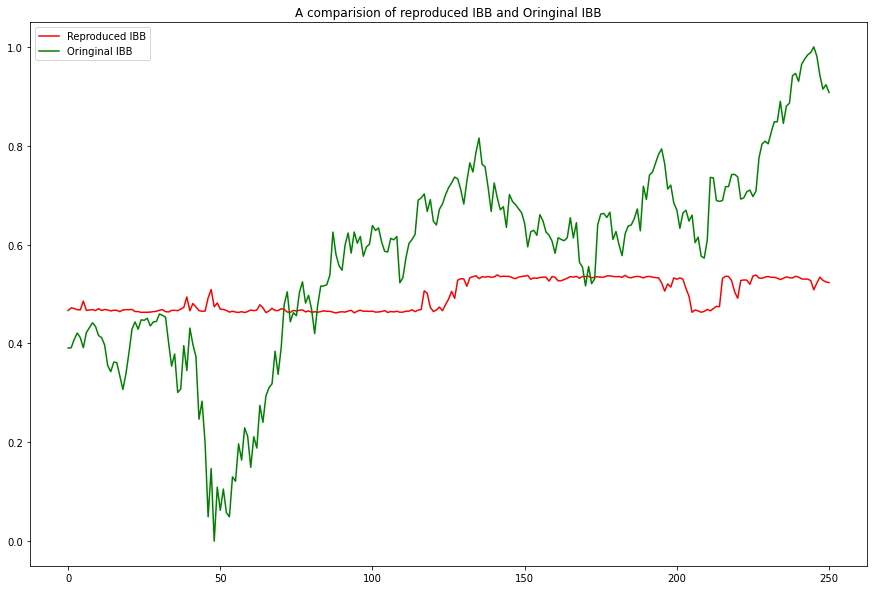

In [ ]:

plt.figure(figsize=(15,10))
plt.plot(Y_valid_output.reshape(-1,1),label="Reproduced IBB",color="red")
plt.plot(Y_valid.reshape(-1,1),label="Oringinal IBB",color="green")

plt.title("A comparision of reproduced IBB and Oringinal IBB")
plt.legend()


## Reproduce the modified IBB: plot a comparison of the new portfolio and the modified IBB on the validation data

In [ ]:
Y_valid_output_mod = autoencoder.predict(Y_valid_mod.reshape(1,-1))

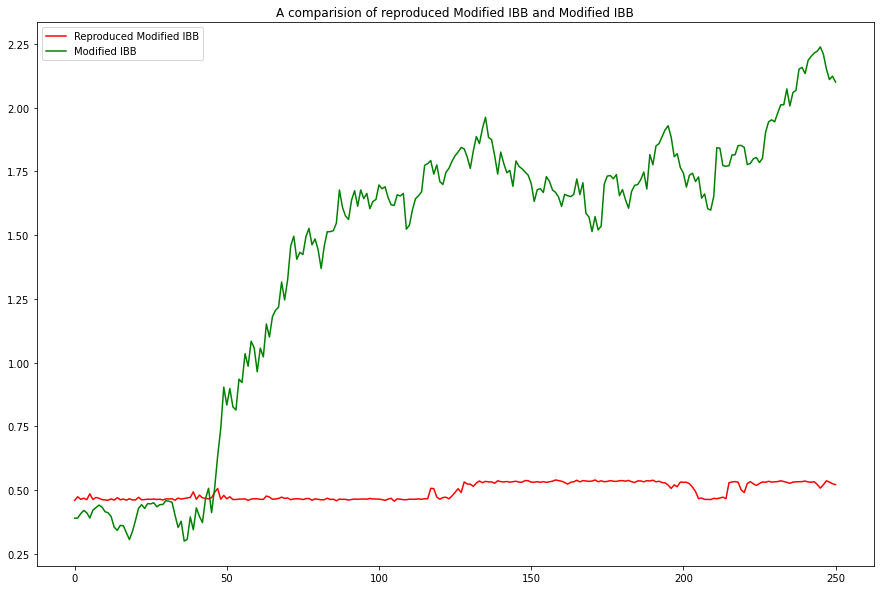

In [ ]:

plt.figure(figsize=(15,10))
plt.plot(Y_valid_output_mod.reshape(-1,1),label="Reproduced Modified IBB",color="red")
plt.plot(Y_valid_mod.reshape(-1,1),label="Modified IBB",color="green")

plt.title("A comparision of reproduced Modified IBB and Modified IBB")
plt.legend()


#5. Evaluate the portfolio on the time period of the validation data.


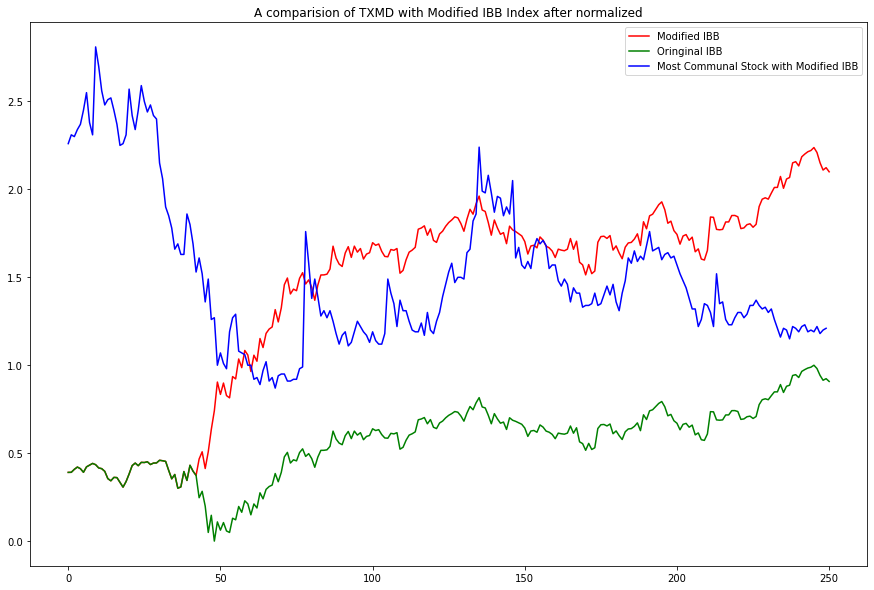

In [ ]:

plt.figure(figsize=(15,10))
plt.plot(Y_valid_mod,label="Modified IBB",color="red")
plt.plot(Y_valid.reshape(-1,1),label="Oringinal IBB",color="green")
plt.plot(X_valid[np.where(tickers == "TXMD")[0][0]],label="Most Communal Stock with Modified IBB", color="blue")

plt.title("A comparision of TXMD with Modified IBB Index after normalized")
plt.legend()
